# Install these packages to get started

In [1]:
import numpy as np
import tensorflow as tf
import IPython
import matplotlib.pyplot as plt
import functools
import pandas as pd
import seaborn as sns
from tqdm import tqdm
#from jupyterthemes import jtplot
#jtplot.style()

# Verify if you use GPU ()
The output should be: " [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')] "

In [2]:
physical_devices = tf.config.list_physical_devices("GPU")
print(physical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Load Data
Make sure you have the right files in the notebook path

**Data for Sea Level-Pressure**

In [3]:
Y_train = pd.read_csv('Y_train_surge.csv')
Y_train = Y_train.to_numpy()
surge_input = Y_train[:,1:21].astype(np.float32)

data = np.load("X_train_surge_new.npz")
slp = data["slp"].astype(np.float32) #the 40 sea-level pressure (SLP) fields, encoded in images of size (41, 41).

In [4]:
data_test = np.load("X_test_surge_new.npz")
slp_test =  data_test["slp"].astype(np.float32)

# Visualization 
Have a look at some samples of slp and surge

[33 28  0 37]


<Figure size 460.8x403.2 with 0 Axes>

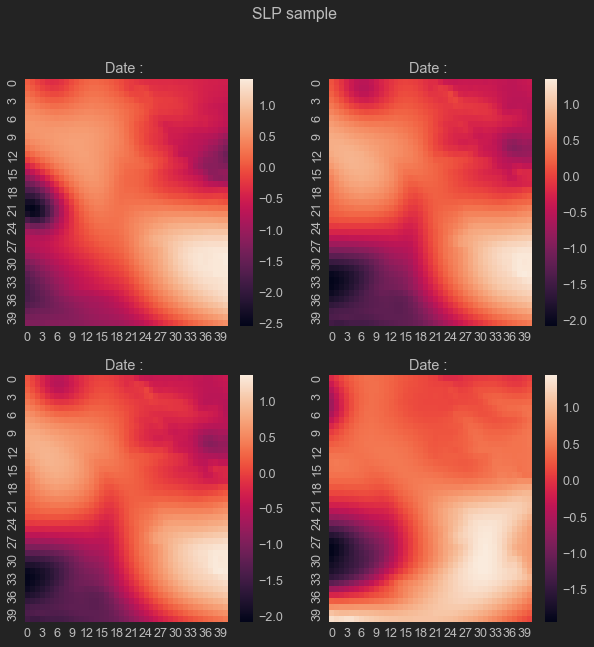

In [34]:
## SLP
plt.figure()
line = 98
random_inds = np.random.choice(slp.shape[1],4)
print(random_inds)
fig, axes = plt.subplots(2,2,figsize = (10,10))
fig.suptitle('SLP sample')
for i in range(2):
    for j in range(2):
        image_ind = random_inds[i+j]
        sns.heatmap(ax = axes[i,j], data = slp[line,image_ind,:,:,0]).set(title='Date : ')

[1547 3938 4413 1210]


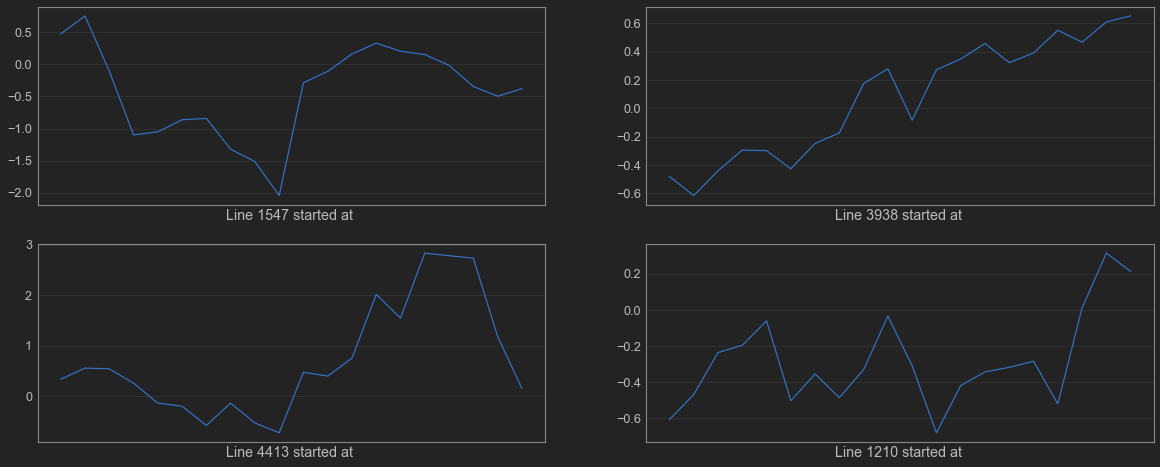

In [35]:
## Surge
plt.figure(figsize=(20,8))
random_inds = np.random.choice(surge_input.shape[0],4)
print(random_inds)
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.xticks([])
    image_ind = random_inds[i]
    plt.plot(surge_input[image_ind,:])
    plt.xlabel('Line '+ str(image_ind)+ ' started at ')

# Data Normalization

In [5]:
### SLP ###
shape = slp.shape
mean_slp = np.mean(slp)
std_slp = np.std(slp)
slp = np.reshape((slp-mean_slp)/std_slp,(shape[0],shape[1],shape[2],shape[3],1))
shape = slp_test.shape
slp_test = np.reshape((slp_test-mean_slp)/std_slp,(shape[0],shape[1],shape[2],shape[3],1))

#### SURGE #####
mean_surge = np.mean(surge_input)
std_surge = np.std(surge_input)
surge_input = (surge_input-mean_surge)/std_surge

# Train and test split

In [6]:
np.random.seed(0) #Fix the seed to 0 to have the same random as others in the group
## indexes for train and test set
train_set_idx = np.random.choice(slp.shape[0],int(slp.shape[0]*0.9),replace = False)
test_set_idx = np.delete(np.arange(slp.shape[0]),train_set_idx)

## TRAIN SET
train_slp = slp[train_set_idx]
train_surge = surge_input[train_set_idx]
### TEST SET
test_slp = slp[test_set_idx]
test_surge = surge_input[test_set_idx]


print(train_slp.shape)
print(train_surge.shape)

(5039, 40, 41, 41, 1)
(5039, 20)


# Loss Function
We define here a weighted Mean Squared Error used in the challenge'score. 

In [7]:
def custom_loss_function(y, y_recon,weight=[1,0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1]):
    weight = tf.convert_to_tensor(weight, dtype=tf.float32)
    substract = tf.math.square(y-y_recon)
    loss = tf.reduce_mean(tf.math.multiply(weight,substract))
    return loss

# Basic architecture of our model

In [24]:
n_filters = 12 # base number of convolutional filters, same as standard CNN

def make_standard_cnn(n_outputs=10):
    #Rename the layers
    Conv3D = functools.partial(tf.keras.layers.Conv3D, activation='relu')
    BatchNormalization = tf.keras.layers.BatchNormalization
    Maxpool = tf.keras.layers.MaxPool3D
    Flatten = tf.keras.layers.Flatten
    Dense = functools.partial(tf.keras.layers.Dense, activation='tanh')
    
    #define the model with Sequential API of TensorFlow
    model = tf.keras.Sequential([

        Conv3D(filters=int(1*n_filters), kernel_size=(4,3,3),strides=(2,1,1)),
        Maxpool(),

        Conv3D(filters=int(2*n_filters), kernel_size=3,  strides=(1,1,1)),
        #Maxpool(),

        Conv3D(filters=int(3*n_filters), kernel_size=3,  strides=(1,1,1)),
        Maxpool(pool_size=(1, 2, 2)),
        BatchNormalization(),

        Conv3D(filters=int(4*n_filters), kernel_size=2,  strides=(1,1,1)),
        BatchNormalization(),

        Flatten(),
        Dense(80),
        tf.keras.layers.Dropout(rate=0.25),
        Dense(80),
        tf.keras.layers.Dropout(rate=0.5),
        Dense(n_outputs, activation=None), 
  ])
  return model


# Not our Model
The first compilling is to have an idea of the paramters in our model. Have a look at the summary() 

In [25]:
model = make_standard_cnn()
model.build(input_shape = train_slp.shape)
model.compile(optimizer = tf.keras.optimizers.SGD(learning_rate=1e-2), 
              loss='MeanSquaredError',
              metrics=['RootMeanSquaredError'
                      ])
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_28 (Conv3D)          (5039, 19, 39, 39, 12)    444       
                                                                 
 max_pooling3d_15 (MaxPoolin  (5039, 9, 19, 19, 12)    0         
 g3D)                                                            
                                                                 
 conv3d_29 (Conv3D)          (5039, 7, 17, 17, 24)     7800      
                                                                 
 conv3d_30 (Conv3D)          (5039, 5, 15, 15, 36)     23364     
                                                                 
 max_pooling3d_16 (MaxPoolin  (5039, 5, 7, 7, 36)      0         
 g3D)                                                            
                                                                 
 batch_normalization_14 (Bat  (5039, 5, 7, 7, 36)     

# Our Model

In [26]:
class custom_CNN(tf.keras.Model):
    def __init__(self, n_output=10):
        super(custom_CNN, self).__init__()
        self.n_output= n_output
        self.weight = [1,0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1]
        self.cnn = make_standard_cnn()

  # The call function will be used to pass inputs x through the core CNN
    def call(self, x): 
        reconstruction = self.cnn(x)
        return reconstruction

  # Predict face or not face logit for given input x
    def evaluate(self, x_eval,y_eval):
        y_pred = self.cnn(x_eval)
        weighted_mse = custom_loss_function(y_pred, y_eval,self.weight)
        print(f'Evaluation Loss : {weighted_mse}')
        return weighted_mse

# Training models
To define the training operation, we will use tf.function which is a powerful tool that lets us turn a Python function into a TensorFlow computation graph.

We decide to train 2 different models for the 2 towns.

## First Town

In [ ]:
# Hyperparameters
batch_size = 16
learning_rate1 = 1e-3
num_epochs1 = 100
optimizer1 = tf.keras.optimizers.Adagrad(learning_rate1)

#data saving
loss_history1 = []
eval_loss_hisotry1 = []
total_loss1 = 0

# To define the training operation, we will use tf.function which is a powerful tool 
#   that lets us turn a Python function into a TensorFlow computation graph.
@tf.function
def train_step1(x, y,cnn):
    with tf.GradientTape() as tape:
        # Feed input x into cnn. Note that this is using the CNN call function!
        y_recon = cnn(x)
        loss = custom_loss_function(y, y_recon)
    grads = tape.gradient(loss, cnn.trainable_variables)
    optimizer1.apply_gradients(zip(grads, cnn.trainable_variables))
    return loss,y_recon

total_eval_loss1 = 0    
cnn1 = custom_CNN()
if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists
        # For the first TOWN
for i in range(num_epochs1):
    #learning rate decay
    """if num_epochs1 > 13 : 
        cosine_decay = 0.7 * (1 + tf.math.cos(np.pi * 4 / 13))
        learning_rate1 = learning_rate1*cosine_decay
        optimizer1 = tf.keras.optimizers.SGD(learning_rate1)"""

    IPython.display.clear_output(wait=True)
    print("Starting epoch {}/{} and loss1 : {} and eval_loss1 : {} \
            ".format(i+1, num_epochs1,total_loss1,total_eval_loss1))
    # get a batch of training data and compute the training step
    total_loss1 = 0
    total_eval_loss1 = 0
    for j in tqdm(range(train_slp.shape[0] // batch_size)):
        end_index = min(train_slp.shape[0],(j+1)*batch_size)
            # load a batch of data
        (x, y) = (train_slp[j*batch_size:end_index],train_surge[j*batch_size:end_index,:10])
        # loss optimization
        loss1,y_recon = train_step1(x, y,cnn1)
        total_loss1 += loss1 
    total_eval_loss1 = cnn1.evaluate(test_slp,test_surge[:,:10])
    eval_loss_hisotry1.append(total_eval_loss1)
    total_loss1 = total_loss1/(train_slp.shape[0] // batch_size)
    loss_history1.append(total_loss1)
                     
"""#PLOT
plt.subplot(1,2,1)
plt.plot(np.linspace(1,num_epochs1,num_epochs1),loss_history1)
plt.subplot(1,2,2)
plt.plot(np.linspace(1,num_epochs1,num_epochs1),eval_loss_hisotry1)"""

Starting epoch 4/100 and loss1 : 0.40622857213020325 and eval_loss1 : 0.40317583084106445             


 95%|████████████████████████████████████████████████████████████████████████████▏   | 299/314 [00:16<00:00, 17.50it/s]

## Second Town

In [ ]:
train_surge2 = np.copy(train_surge[:,10:])

In [ ]:
#Hyperparameters
batch_size = 16
learning_rate2 = 1e-3
num_epochs2= 100
optimizer2 = tf.keras.optimizers.SGD(learning_rate2)

#Saving DAta
loss_history2 = []
eval_loss_hisotry2 = []
total_loss2 = 0

@tf.function
def train_step2(x, y,cnn):
    with tf.GradientTape() as tape:
            # Feed input x into cnn. Note that this is using the CNN call function!
        y_recon = cnn(x)
        loss = custom_loss_function(y, y_recon)
    grads = tape.gradient(loss, cnn.trainable_variables)
    optimizer2.apply_gradients(zip(grads, cnn.trainable_variables))
    return loss,y_recon

    
# For the SECOND TOWN 
cnn2 = custom_CNN()
total_eval_loss2 = 0
if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists
for i in range(num_epochs2):
        IPython.display.clear_output(wait=True)
        print("Starting epoch {}/{} and loss2 : {} and eval_loss2 : {} \
        ".format(i+1, num_epochs2,total_loss2,total_eval_loss2))
        total_loss2 = 0
        total_eval_loss2 = 0
          # get a batch of training data and compute the training step
        for j in tqdm(range(train_slp.shape[0] // batch_size)):
            end_index = min(train_slp.shape[0],(j+1)*batch_size)
            # load a batch of data
            (x, y) = (train_slp[j*batch_size:end_index],train_surge2[j*batch_size:end_index])
            # loss optimization
            loss2,y_recon = train_step2(x, y,cnn2)
            total_loss2 += loss2 
                
        total_eval_loss2 = cnn2.evaluate(test_slp,test_surge[:,10:])
        eval_loss_hisotry2.append(total_eval_loss2)
        total_loss2 = total_loss2/(train_slp.shape[0] // batch_size)
        loss_history2.append(total_loss2)

plt.subplot(1,2,1)
plt.plot(np.linspace(1,num_epochs2,num_epochs2),loss_history2)
plt.subplot(1,2,2)
plt.plot(np.linspace(1,num_epochs2,num_epochs2),eval_loss_hisotry2)

In [18]:
cnn1.evaluate(test_slp,test_surge[:,:10])
cnn2.evaluate(test_slp,test_surge[:,10:])

Evaluation Loss : 0.3345368206501007
Evaluation Loss : 0.3490586578845978


<tf.Tensor: shape=(), dtype=float32, numpy=0.34905866>

In [19]:
y_pred1 = cnn1(slp_test).numpy()
y_pred2 = cnn2(slp_test).numpy()
y_pred = np.concatenate((y_pred1,y_pred2),axis=1)
y_pred = (y_pred*std_surge)+mean_surge
print(y_pred.shape)
print(y_pred[0,0],y_pred1[0,0],y_pred[0,10],y_pred2[0,0])

(509, 20)
-0.92148006 -0.92374855 -0.48265445 -0.48135227


[103 339 463 256]


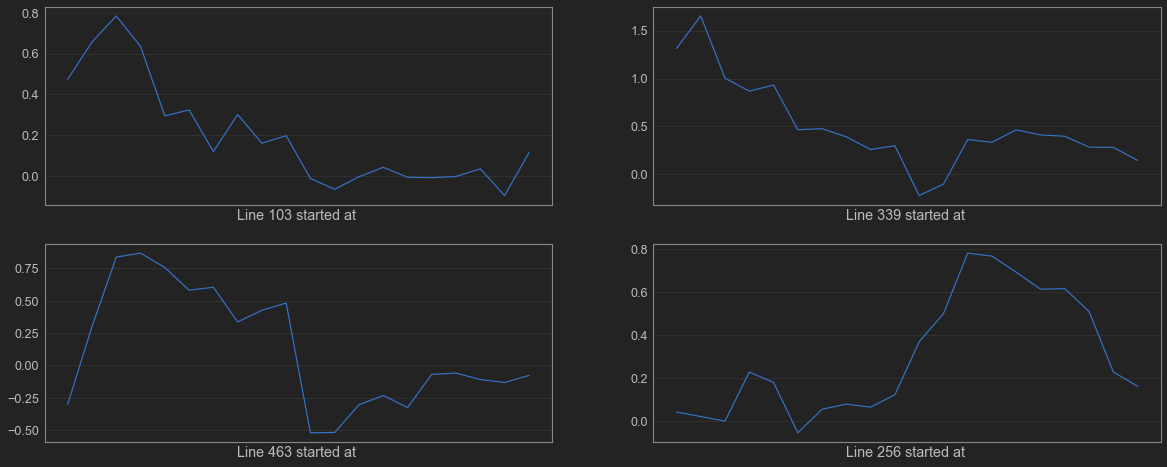

In [20]:
plt.figure(figsize=(20,8))
random_inds = np.random.choice(y_pred.shape[0],4)
print(random_inds)
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.xticks([])
    image_ind = random_inds[i]
    plt.plot(y_pred[image_ind,:])
    plt.xlabel('Line '+ str(image_ind)+ ' started at ')

In [21]:
y_columns = [f'surge1_t{i}' for i in range(10)] + [f'surge2_t{i}' for i in range(10)]
y_test_benchmark = pd.DataFrame(data=y_pred, columns=y_columns, index=data_test['id_sequence'])
y_test_benchmark.to_csv('surge_predicted_custom_CNN2.csv', index_label='id_sequence', sep=',')